## <font color = '#6495ED'>  ________________ **Reinforcement Learning - Lunar Lander** _________________
#### _______________________________________________Academic Year: 2024/2025 _____________________________________________

<div style="text-align: center;">
    <strong>Group Members</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Afonso Ascenção</td>
            <td style="border: 1px solid white; padding: 8px;">20240684</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Afonso Silva</td>
            <td style="border: 1px solid white; padding: 8px;">20240495</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Elcano Gaspar</td>
            <td style="border: 1px solid white; padding: 8px;">20241021</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Osmáiny Leontina</td>
            <td style="border: 1px solid white; padding: 8px;">20191506</td>
        </tr>
    </table>
</div>

### <font color = '#6495ED'>**Project Description**</font>

#### *Objective:*
The goal of this project is to develop and evaluate two Reinforcement Learning (RL) agents capable of solving two distinct environments from the Gymnasium library. The project aims to explore the design and implementation of RL algorithms in environments with diverse state and action spaces.

#### *Environments:*
We choose two different environments from the Gymnasium library that were not covered in class. At least one environment must have a non-discrete/non-tabular observation space (e.g., continuous or mixed).

#### *Methodology:*
The project follow these steps:

- Environment Selection: Choose two distinct Gymnasium environments, with at least one having a non-discrete observation space.
- Algorithm Implementation: Implement two different RL algorithms (SARSA and PPO) for each chosen environment.
- Agent Training: Train the developed RL agents in their respective environments.
- Evaluation and Analysis: Record and analyze performance metrics such as total reward per episode/return, convergence speed, and the balance between exploration and exploitation.
- Visualization: Provide visualizations of learning progress, including reward curves and success rates.
- Comparative Analysis: Perform a comparative analysis of the chosen algorithms and environments.
- Behavior Interpretation: Interpret and explain the agent's behavior in each environment, analyzing its actions and learning patterns.

#### *Success Metrics:*
Our primary success metrics will include:

Total Reward per Episode/Return: To measure the overall performance of the agent.
Convergence Speed: To evaluate how quickly the agent learns an effective policy.
Exploration vs. Exploitation Balance: To understand the agent's strategy for discovering and leveraging rewards.
Visualizations: Clarity and interpretability of plots representing learning and performance.

Argumentation of Methods: The usage and argumentation of different learning methods, their relevance, and usefulness in solving the problem will be the focus of the evaluation.

#### *Variable description:*
| **ATTRIBUTE**               | **DESCRIPTION**                                                                                   |
|-----------------------------|---------------------------------------------------------------------------------------------------|
| State               | The current observation of the environment, used by the agent to make decisions.                                 |
| Action               | The decision made by the agent at a given state, which affects the environment.                                       |
| label               | A scalar feedback signal from the environment indicating the immediate success or failure of an action, used to guide agent learning        |

### <font color = '#6495ED'>  **1. Libraries, Environment, Configuration** </font>

#### <font color = '#6495ED'> **1.1. Import the Needed Libraries** </font>

In [24]:
#!pip install gymnasium[box2d]
#!pip install swig
#!pip install gymnasium[other]

In [25]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.vec_env import VecVideoRecorder
from IPython.display import Video
import os
from collections import deque

#### <font color = '#6495ED'> **1.2. Environment - Lunar Lander Continuous-V3** </font>

This environment is part of the Box2D environments. This continuous control task requires a lander to touch down softly at the center of a landing pad using two engine thrusters.

- **State space**: 8D vector [position, velocity, angle, angular velocity, left/right leg contact]
- **Action space**: 2D continuous vector (main engine, side engine)
- **Goal**: Land without crashing
- **Reward**: Based on proximity to landing zone, velocity, angle, leg contact, and fuel use

In [26]:
def make_env(env_name, seed=None, render_mode=None, **kwargs):
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = Monitor(env)
    if seed is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    return env

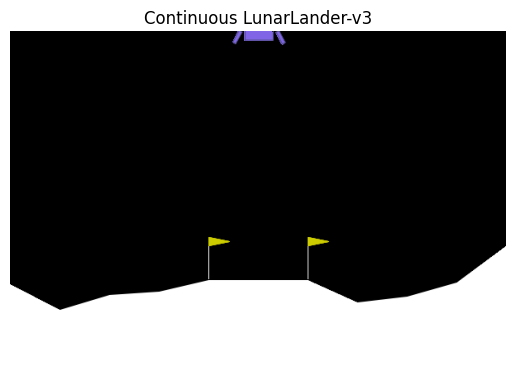

Observation space shape: (8,)
Action space shape: (2,)
Action range: [-1. -1.] to [1. 1.]
Sample observation: [ 0.0031414   1.402389    0.31817257 -0.3791557 ]...


In [27]:
# Render the environment to visualize it

# Choosing the continuous version of Lunar Lander
env_name = 'LunarLanderContinuous-v3'

# Create the environment
env = make_env(
    env_name,
    render_mode='rgb_array'
)

# Reset the environment to get the initial observation
obs, info = env.reset()

# Render initial state with matplotlib
plt.imshow(env.render())
plt.axis('off')
plt.title("Continuous LunarLander-v3")
plt.show()

# Print observation and action space details
print(f"Observation space shape: {env.observation_space.shape}")  # 8 values
print(f"Action space shape: {env.action_space.shape}")  # [2] for continuous
print(f"Action range: {env.action_space.low} to {env.action_space.high}")  # [-1,-1] to [1,1]
print(f"Sample observation: {obs[:4]}...")

# Close the environment
env.close()

In [28]:
# Create a vectorized environment for training and evaluation

# Create a vectorized environment for training
train_env = make_vec_env(env_name, n_envs=1)
# Normalize observations and rewards for better training stability
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.) # reward_norm = (reward - running_mean) / (running_std + ε)

# Create a vectorized environment for evaluation
eval_env = make_vec_env(env_name, n_envs=1)
# Normalize observations and rewards for evaluation
eval_env = VecNormalize(eval_env, training=False, norm_obs=True, norm_reward=True, clip_obs=10.)

# Copy the observation normalization statistics from training to evaluation
eval_env.obs_rms = train_env.obs_rms

### Build Actor Critic Network

We will build two simple networks that take in state. One network produces parameters for a continuous distribution (for continuous action spaces). The second network produces the Value of the state. The observation space and action space for LunarLander are given below for both its discrete and continuous action versions.

    Observation:
        Type: Box(8) - continuous
        Num     Observation               Min                             Max
        0       Lander X Position         -1.5                            1.5
        1       Lander Y Position         -1.5                            1.5
        2       Lander X Velocity         -5.0                            5.0
        3       Lander Y Velocity         -5.0                            5.0
        4       Lander Angle              -3.14 rad (approx -180 deg)     3.14 rad (approx -180 deg)
        5       Lander Angular Velocity   -5.0                            5.0
        6       Left Leg Contact           0                              1
        7       Right Leg Contact          0                              1
    Actions:
        Type: Continuous (2)
        Num     Action                    Min                             Max
        0:      Main Engine Throttle     -1.0                             1.0
        1:      Side Engines Throttle    -1.0                             1.0

Continuous Actions: For the main engine, values < 0 turn it off; values from 0 to 1 scale throttle from 50% to 100%. For side engines, values between -0.5 and 0.5 do nothing; values from -1.0 to -0.5 fire the left booster (50% to 100% throttle); values from 0.5 to 1.0 fire the right booster (50% to 100% throttle).

### <font color = '#6495ED'>  **2. Model** </font>

In [29]:
# Early StoppingCallback
class RewardCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=10_000):
        super().__init__() # Initialize the base class
        self.eval_env = eval_env # Environment for evaluation
        self.eval_freq = eval_freq # Frequency of evaluation
        self.episode_rewards = [] # List to store rewards per episode
        self.episode_lengths = [] # List to store lengths of episodes
        self.entropy_vals = [] # List to store entropy values
        self.rolling_rewards = deque(maxlen=100)

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            infos = self.locals["infos"]
            for info in infos:
                if "episode" in info:
                    reward = info["episode"]["r"] # Get the reward of the episode
                    self.episode_rewards.append(reward) # Append the reward of the episode
                    self.rolling_rewards.append(reward) # Append the reward to the rolling rewards deque

                    self.episode_lengths.append(info["episode"]["l"]) # Append the length of the episode

                    avg_rolling = np.mean(self.rolling_rewards)
                    print('\rEpisode {}\tAverage Score: {:.2f}'.format(len(self.episode_rewards), avg_rolling), end = "")

                    if len(self.episode_rewards) % 100 == 0:
                        print('\rEpisode {}\tAverage Score: {:.2f}'.format(len(self.episode_rewards), avg_rolling))

                    if avg_rolling >= 200.0:
                        print(f"Environment solved in {len(self.episode_rewards)-100} episodes! Average Score: {avg_rolling:.2f}")
                        self.model.stop_training = True
                        return False

        # Evaluate the model at specified intervals
        if self.n_calls % self.eval_freq == 0:
            self.entropy_vals.append(float(self.model.logger.name_to_value.get("train/entropy_loss", 0))) # Append the entropy value to entropy_vals

        return True

In [30]:
# Define the policy architecture for the PPO agent
policy_kwargs = dict(net_arch=dict(pi=[256, 128, 128, 64], vf=[256, 128, 128, 64])) # Policy architecture with 3 layers for both policy (pi) and value function (vf).

model = PPO(
    "MlpPolicy", # Use Multi-Layer Perceptron (MLP) policy
    train_env, # Training environment
    policy_kwargs=policy_kwargs, # Policy architecture
    verbose=0, # Verbosity level for logging
    learning_rate=5e-4, # Learning rate for the optimizer
    n_steps=4096, # Number of steps to run per update
    batch_size=256, # Batch size for training
    n_epochs=10, # Number of epochs to update the policy
    gamma=0.99, # Discount factor for future rewards
    gae_lambda=0.95, # Lambda parameter for Generalized Advantage Estimation (GAE)
    clip_range=0.2, # Clipping range for PPO to prevent large policy updates
    ent_coef=0.001, # Coefficient for the entropy term in the loss function
    device='cpu' # Device to run the model on (CPU or GPU)
)

#### <font color = '#6495ED'> **2.1. Train the PPO Agent** </font>

In [7]:
# Set up callbacks for logging rewards, early stopping, and evaluation

# Create the reward callback to log episode rewards and entropy values
reward_callback = RewardCallback(eval_env=eval_env, eval_freq=10_000)


# Create the evaluation callback to evaluate the model periodically and save the best model
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=10_000,
    deterministic=True,
    render=False,
    verbose=0  # Suppress all output
)

# Starting timer
start_time = time.time()

# Train the PPO model with the defined callbacks
model.learn(total_timesteps=1_000_000, callback=[reward_callback, eval_callback])

# Ending timer and calculating elapsed time
elapsed_time = time.time() - start_time
print(f"\n Training complete in {elapsed_time:.2f} seconds")

# Save the model and normalization statistics
model.save("ppo_lunarlander_continuous")
train_env.save("ppo_lunarlander_continuous_vecnormalize.pkl")
print("Model and VecNormalize stats saved.")

Episode 100	Average Score: -193.83
Episode 200	Average Score: -38.189
Episode 300	Average Score: 66.645
Episode 400	Average Score: 95.521
Episode 500	Average Score: 49.47
Episode 600	Average Score: 86.97
Episode 700	Average Score: 140.73
Episode 800	Average Score: 153.89
Episode 900	Average Score: 166.34
Episode 995	Average Score: 200.90Environment solved in 895 episodes! Average Score: 200.90

 Training complete in 1142.30 seconds
Model and VecNormalize stats saved.


#### <font color = '#6495ED'> **2.2. Evaluate the PPO Agent** </font>

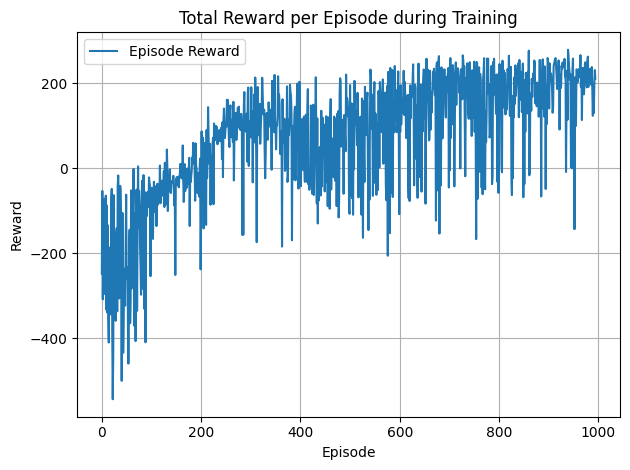

In [8]:
# Plot the training progress and rewards
plt.plot(reward_callback.episode_rewards, label="Episode Reward")
plt.title("Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

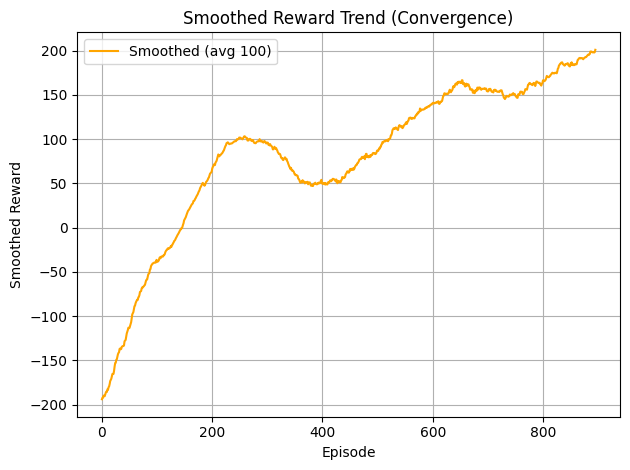

In [9]:
# Plot the smoothed reward trend to visualize convergence
window = 100
smoothed = np.convolve(reward_callback.episode_rewards, np.ones(window)/window, mode='valid')
plt.plot(smoothed, label=f"Smoothed (avg {window})", color="orange")
plt.title("Smoothed Reward Trend (Convergence)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

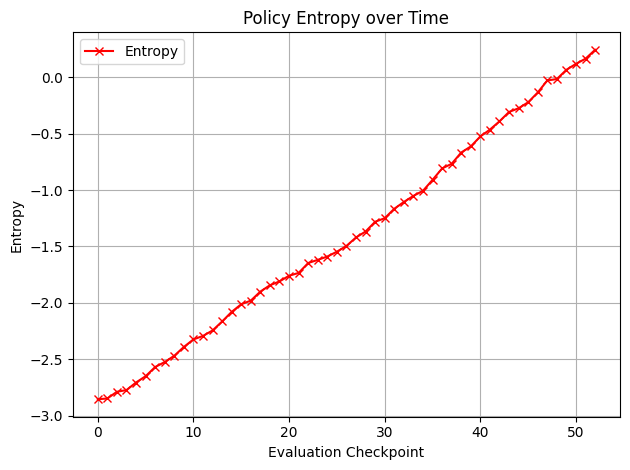

In [10]:
# Policy Entropy Plot
plt.plot(reward_callback.entropy_vals, label="Entropy", color='red', marker='x')
plt.title("Policy Entropy over Time")
plt.xlabel("Evaluation Checkpoint")
plt.ylabel("Entropy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100, render=False)
print(f"\n Mean reward over 100 episodes: {mean_reward:.2f} +/- {std_reward:.2f}")


 Mean reward over 100 episodes: 216.98 +/- 53.78


### <font color = '#6495ED'>  **3. Agent Video** </font>

In [13]:
video_dir = './ppo_lander_video/'
os.makedirs(video_dir, exist_ok=True)

dummy_env = make_vec_env(env_name, n_envs=1)
video_env = VecNormalize.load('ppo_lunarlander_continuous_vecnormalize.pkl', dummy_env)
video_env.training = False
video_env.norm_reward = True

# Load the trained model
model = PPO.load('ppo_lunarlander_continuous', env=video_env)

# Wrap with VecVideoRecorder for 10,000 steps
video_env = VecVideoRecorder(
    video_env,
    video_folder=video_dir,
    record_video_trigger=lambda x: x == 0,
    video_length=10000,
    name_prefix='ppo_lander'
)

# Record up to N steps, restarting the env if done
obs = video_env.reset()
steps = 0
while steps < 10000:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, dones, infos = video_env.step(action)
    steps += 1
    if dones.any():
        obs = video_env.reset()
video_env.close()

# Display the correct video file (steps 0 to 10000)
Video(f"{video_dir}/ppo_lander-step-0-to-step.mp4", embed=True)

C:\Users\afons\scoop\apps\miniconda3\current\envs\RL_proj\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Saving video to C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-10000.mp4
MoviePy - Building video C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-10000.mp4.
MoviePy - Writing video C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-10000.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-10000.mp4


### <font color = '#6495ED'>  **4. Agent in action** </font>

In [31]:
# Load the trained model
model = PPO.load('ppo_lunarlander_continuous')

# Create the environment for human rendering
env = gym.make(env_name, render_mode="human")
obs, info = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)  # Use deterministic for evaluation
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    time.sleep(0.03)
    if truncated:
        break

env.close()